# Workflow For Designing Closed Loop Systems

PID Feedback Architecture

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

State Feedback Architecture (without disturbance and noise)

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_24-Testbed-for-Full-State-Feedback/Full-State-Feedback.png?raw=true"
alt="Markdown Monster icon"
width=500pt
style="float: left; margin-right: 10px;" />

This notebook develops closed loop systems for SBML models to elucidate the underlying workflow.

# Issues

1. Include noise and disturbance

# Preliminaries

## Imports

In [1]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

## Constants

In [2]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)
SYSTEM = "system"
CONTROLLER = "controller"
CONTROLLER_IN = "controller.in"
CONTROLLER_REF = "controller.ref"
CONTROLLER_OUT = "controller.out"
SIGNAL_SUM = "signal_sum"
SIGNAL_SUM_IN1 = "signal_sum.in1"
SIGNAL_SUM_IN2 = "signal_sum.in2"
SIGNAL_SUM_OUT = "signal_sum.out"

In [3]:
BIOMD823 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
BIOMD206 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"

# Antimony Model

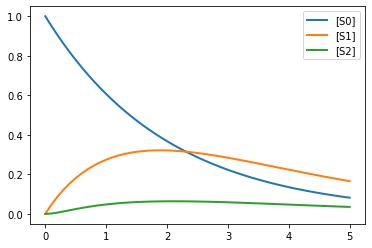

In [4]:
ANT_MODEL = """
S0 -> S1; k0*S0
S1 -> S2; k1*S1
S2 -> S1; k2*S2
S2 -> ; k3*S2

S0 = 0
S1 = 0
S2 = 0
S3 = 0
k0 = 0.5
k1 = 1
k2 = 2
k3 = 3
"""
rr = te.loada(ANT_MODEL)
rr["S0"] = 1
rr.simulate()
rr.plot()

# Model of Glycoytic Oscillations (BioModels 206)

**Reactions in Glycolytic Oscillations**

``at`` is ``ATP``; ``s5`` is ``pyruvate``.

    v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
    v2: s2 -> 2 s3; compartment_*k2*s2;
    v3: s3 + na -> s4 + at_;compartment_*((k31*k32*s3*na*(atot - at_) 
        - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
    v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
    v5: s5 -> s6; compartment_*k5*s5;
    v7: at_ -> ; compartment_*k7*at_;
    v8: s3 -> na; compartment_*k8*s3*(ntot - na);
    v9: s6o -> ; compartment_*k9*s6o;
    v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
    v6: s6 -> na; compartment_*k6*s6*(ntot - na);
    v0:  -> s1; compartment_*k0;

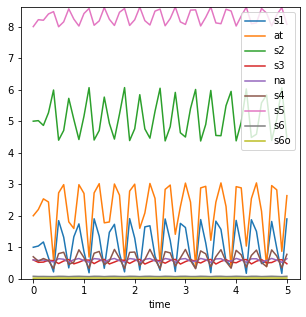

In [5]:
ctlsb = ctl.ControlSBML(BIOMD206)
ctlsb.plotTrueModel(figsize=(5,5))

# Analysis Workflow

## Step 1: Create Analysis Objects

In [31]:
ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=["S1", "S2"])

In [7]:
siso = ctl.SISOClosedLoopSystem(ctlsb)

## Step 2: Evaluate Controllability

In [8]:
siso.evaluateControllability(range(5))

{0:           S1        S2
 S0  0.833333  0.166667,
 1:           S1        S2
 S0  0.833333  0.166667,
 2:           S1        S2
 S0  0.833333  0.166667,
 3:           S1        S2
 S0  0.833333  0.166667,
 4:           S1        S2
 S0  0.833333  0.166667}

## Step 3A: Evaluate PID Closed Loop System

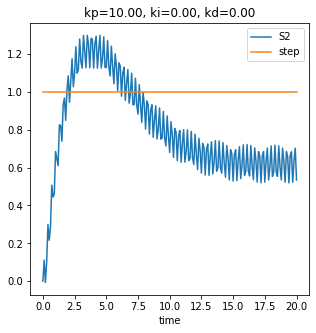

OK!


In [65]:
def evaluatePID(kp=1, ki=0, kd=0, kf=None, is_plot=True):
    ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=["S1", "S2"])
    siso = ctl.SISOClosedLoopSystem(ctlsb)
    siso.makePIDClosedLoopSystem(kp=kp, ki=ki, kd=kd, kf=kf, noise_amp=0.1, noise_frq=20)
    ts = siso.makeStepResponse(end_time=20)
    title = "kp=%2.2f, ki=%2.2f, kd=%2.2f" % (kp, ki, kd)
    if is_plot:
        ctl.plotOneTS(ts, figsize=(5, 5), title=title)
    return ts, siso.factory.report()

# Tests
ts, df = evaluatePID(kp=10, ki=0, kd=0, kf=-0.1, is_plot=True)
assert("Timeseries" in str(type(ts)))
print("OK!")

In [42]:
df.to_csv("siso.csv")

In [43]:
!pwd

/home/ubuntu/advanced-controls-lectures/Lecture_27-Workflow-For-Designing-Closed-Loop-Systems


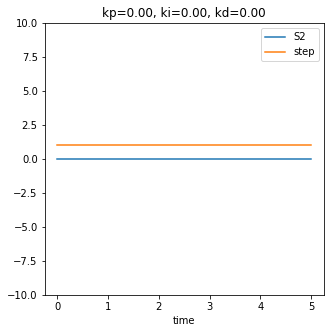

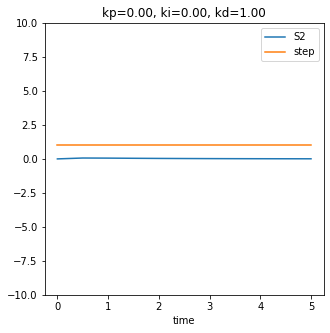

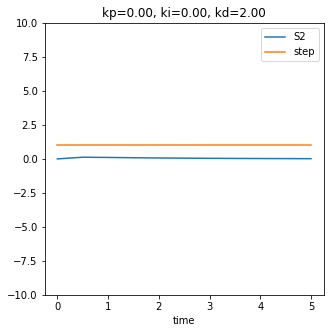

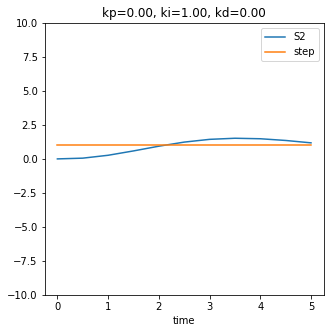

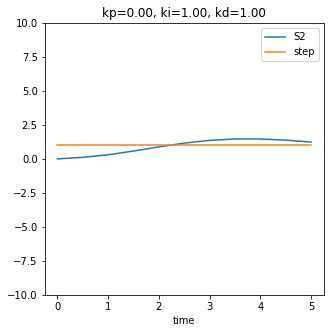

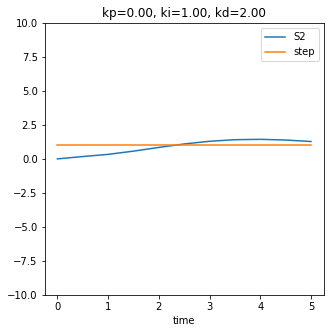

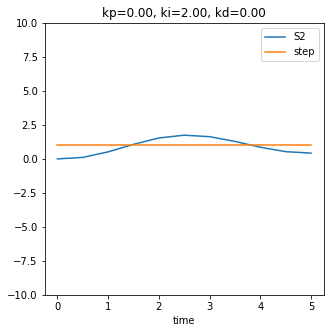

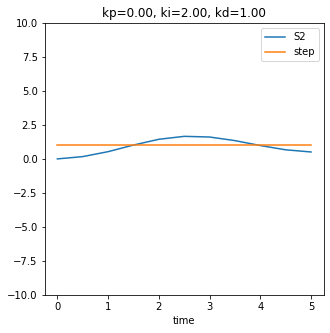

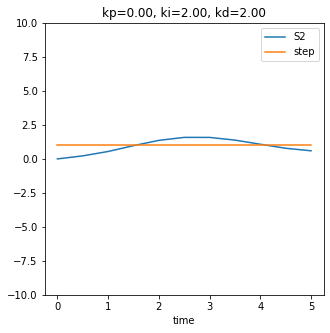

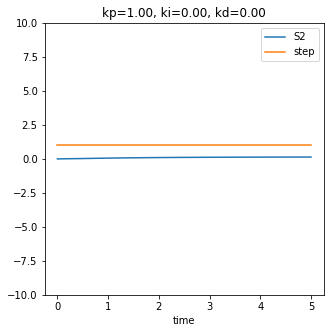

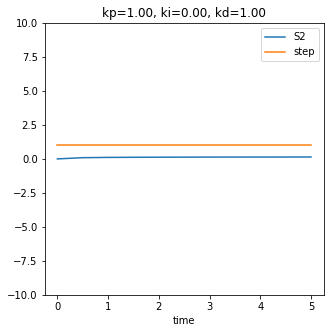

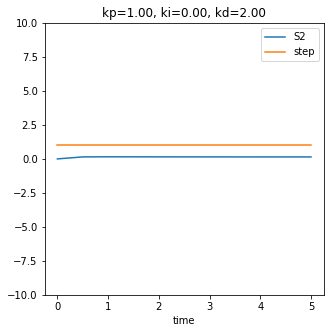

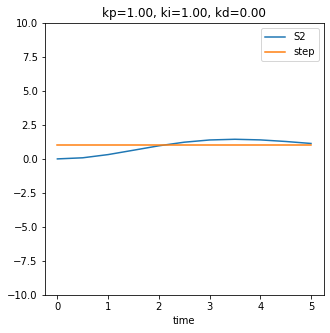

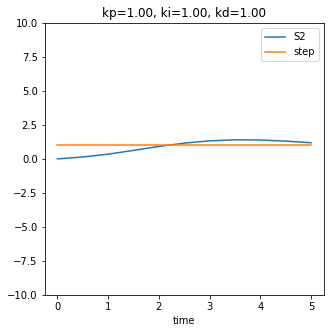

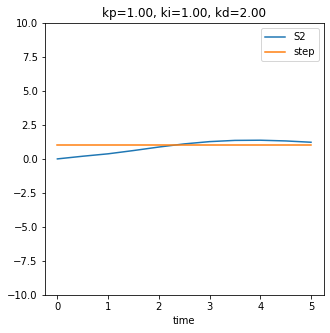

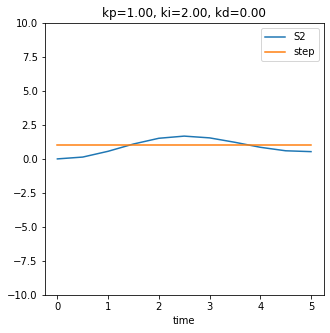

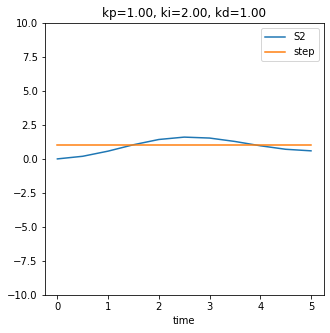

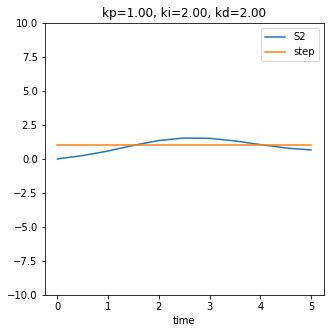

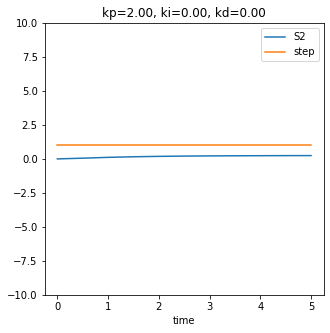

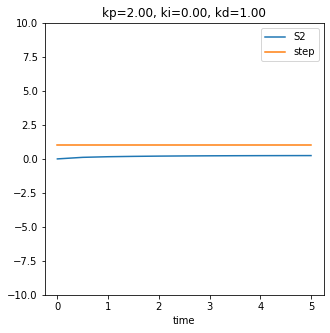

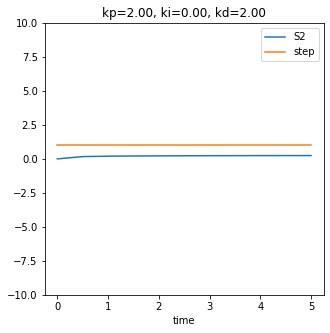

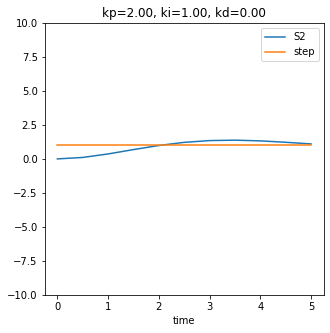

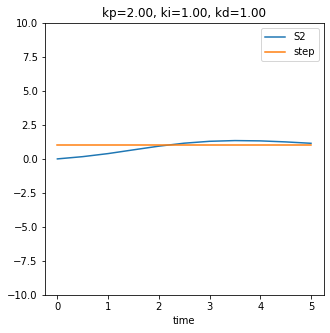

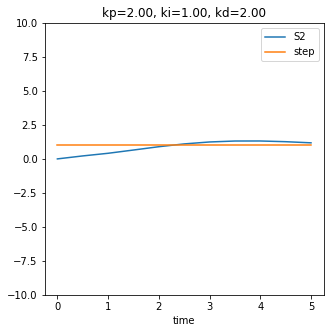

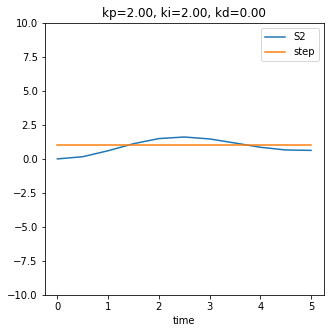

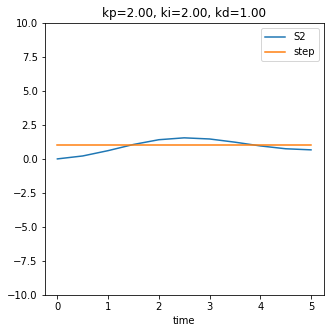

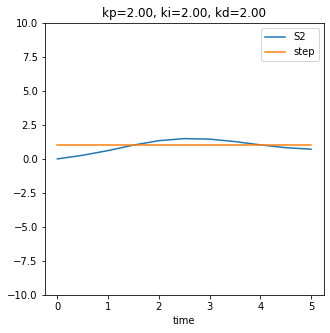

In [22]:
for kp in range(0, 3):
    for ki in range(0, 3):
        for kd in range(0, 3):
            evaluatePID(kp=kp, ki=ki, kd=kd, kf=None)

## Step 3B: Evaluate Full State Closed Loop System

In [11]:
def evaluateFullState(poles=-1, is_plot=True, **kwargs):
    siso = ctl.SISOClosedLoopSystem(ctlsb)
    siso.makeFullStateClosedLoopSystem(poles=poles, noise_amp=0, noise_frq=5,  **kwargs)
    ts = siso.makeStepResponse()
    titles = ["%s=%s" % (str(k), str(v)) for k, v in kwargs.items()]
    titles.insert(0, "pole=%2.2f" % poles)
    title = ", ".join(titles)
    if is_plot:
        ctl.plotOneTS(ts, figsize=(5, 5), title=title, ylim=[-2, 2])
    return ts

# Tests
ts = evaluateFullState(is_plot=False)
assert("Timeseries" in str(type(ts)))
print("OK!")

OK!


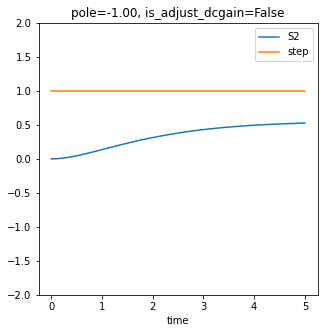

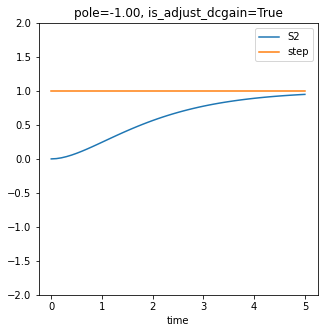

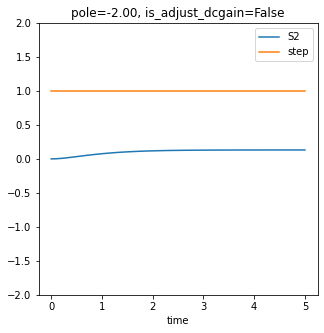

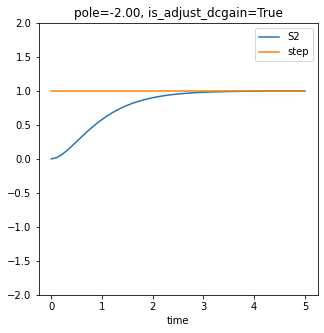

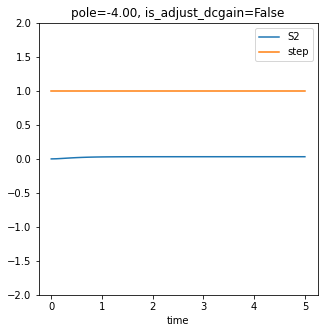

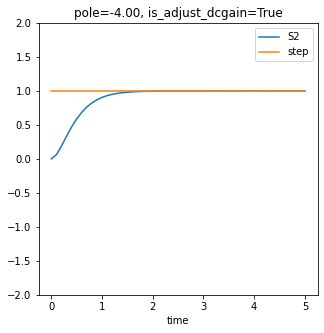

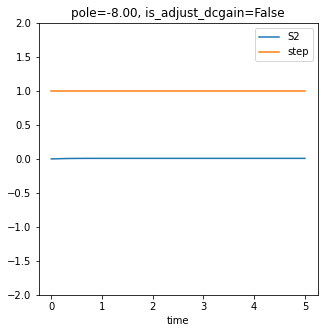

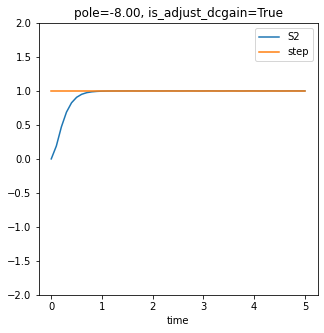

In [12]:
for pole in [-1, -2, -4, -8]:
    for is_adjust_dcgain in [False, True]:
        evaluateFullState(poles=pole, is_adjust_dcgain=is_adjust_dcgain)

## Step 4: Effect of Noise